# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

Good luck & have fun! :)

In [1]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из [семинара 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

In [2]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# You may add any imports you need

In [4]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [5]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2023-11-16 14:31:11--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2023-11-16 14:31:11--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc77ac3189197623e8ebc8eaba4a.dl.dropboxusercontent.com/cd/0/get/CHoWTLS-cYOSmuyUpTf5rAIWUJfGK_3_Ox29AbmZJtY1fZ4nVMEtfWvqi3VOnbOWg0DjqXyrYtBfBf3dxMoct2AL0HRFideCOAlze7EoWcBPrEPT-vi2hP8ocNVUSfF4O8q2QaWxj7FLNRVIMQpwswvD/file?dl=1# [following]
--2023-11-16 14:31:12--  https://uc77ac3189197623e8ebc8eaba4a.dl.dropboxusercontent.com/cd/0/get/CHoWTLS-cYOSmuyUpTf5rAIWUJfGK_3_Ox29AbmZJtY1fZ4nVMEtfWvqi3VOnbOWg0DjqXyrYtBfBf3dxMoct2AL0HRFideCOAlze7E

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

Чтобы рассчитать `mean` и `std` для `Normalize` воспользуемся [статьей](https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html).
В данном случае в аугментации мы не прописываем нормализацию, так как нам необходимо её найти. Из преобразований изображений будем использовать **RandomHorizontalFlip**, **ColorJitter** и **RandomGrayscale** так как они в совокупности лучше всего влияют на наше **accuracy**.

In [6]:
transform_img = transforms.Compose([
        transforms.ColorJitter(hue=0.05, saturation=0.05),
        transforms.RandomGrayscale(p=0.3),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
])

image_data = ImageFolder('/kaggle/working/dataset/dataset/train', transform=transform_img)

image_data_loader = DataLoader(
    image_data,
    # batch size is whole dataset
    batch_size=len(image_data),shuffle=False)

def mean_std(loader):
  images, _ = next(iter(loader))
  # shape of images = [b_s,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std

mean, std = mean_std(image_data_loader)
print(f"mean: {mean} and std: {std}")

mean: tensor([0.4700, 0.4472, 0.4128]) and std: tensor([0.2727, 0.2680, 0.2770])


Мы получили `mean` и `std`, применим их в нормализации:

In [7]:
seed_everything(42)
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4700, 0.4472, 0.4128), (0.2727, 0.2680, 0.2770))
    ]
)

val_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4700, 0.4472, 0.4128), (0.2727, 0.2680, 0.2770))
    ]
)

train_dataset = ImageFolder('/kaggle/working/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/kaggle/working/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)

In [8]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

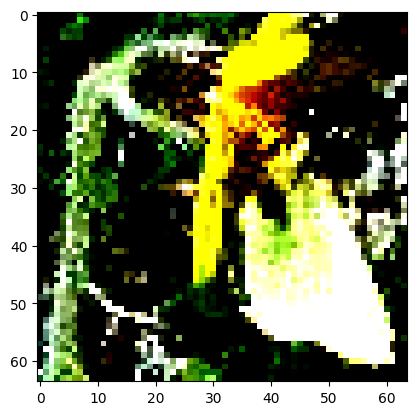

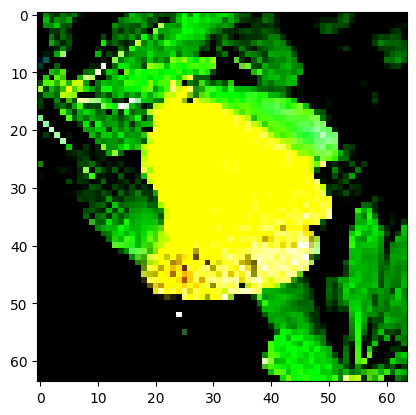

In [9]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

Мы будем импортировать готовую непредобученную модель.


### Тренировочный класс lightning

In [10]:
from torchvision.models import densenet161

class YourNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = densenet161(weights=None, num_classes=200)
        self.model.classifier = nn.Sequential(
                                    nn.Linear(self.model.classifier.in_features, 512),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.2),
                                    nn.Linear(512, 200)
                                )


        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        return self.model(x)

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=200)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [11]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        ac = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='multiclass', num_classes=200)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", ac, prog_bar=True)

In [17]:
seed_everything(42)
wandb.init(project="Task_1", name='densenet161 result')
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = YourNet().to(device)
module = YourModule(model, learning_rate=0.001)

In [18]:
seed_everything(42)
trainer = pl.Trainer(accelerator="gpu", logger=wandb_logger, max_epochs=14)
trainer.fit(module, train_dataloader, val_dataloader)

wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▄▃▃▃▃▂▃▃▂▃▂▂▂▂▂▂▁▁▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▃▄▅▅▆▆▇▇▇████
val_loss,█▆▄▃▃▂▂▁▁▁▁▁▁▁
epoch,13
train_loss,1.32329
trainer/global_step,5473
val_accuracy,0.446
val_loss,2.53035


### Валидация результатов задания

In [19]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=True)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [20]:
ac = evaluate_task(model, val_dataloader)
print(f'Accuracy: {ac}')
print(f"Оценка за это задание составит {np.clip(10 * ac / 0.44, 0, 10):.2f} баллов")

100%|██████████| 40/40 [00:08<00:00,  5.00it/s]

Accuracy: 0.45458984375
Оценка за это задание составит 10.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [32]:
seed_everything(42)
train_transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=0.05),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomGrayscale(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize((0.4700, 0.4472, 0.4128), (0.2727, 0.2680, 0.2770))
    ]
)

val_transform = torchvision.transforms.Compose(
    [
        transforms.Resize(224),
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4700, 0.4472, 0.4128), (0.2727, 0.2680, 0.2770))
    ]
)

train_dataset = ImageFolder('/kaggle/working/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/kaggle/working/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)

In [22]:
class YourNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        pass

    def _forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE
        pass

    def forward(self, images, target=None):
        # YOUR CODE HERE
        pass

    def get_accuracy(self, reset=False):
        # YOUR CODE HERE
        pass

### Тренировочный класс lightning

In [23]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate, pretrained: bool = False):
        super().__init__()
        self.pretrained = pretrained
        self.model = model
        self.learning_rate = learning_rate
        self.in_features = self.model.heads.head.in_features
        conv = nn.Sequential(
                              nn.Linear(self.in_features, 512),
                              nn.LeakyReLU(),
                              nn.Dropout(p=0.2),
                              nn.Linear(512, 200)
                            )
        if pretrained:
            self.model.heads = nn.Identity()
            self.classifier = conv
            self.optimizer = torch.optim.Adam(self.classifier.parameters())
        else:
            self.model.head = conv
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        if self.pretrained:
            with torch.no_grad():
                features = self.model(x)
            preds = self.classifier(features)
        else:
            preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='multiclass', num_classes=200)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)

In [24]:
from torchvision.models import vit_b_16

In [25]:
seed_everything(42)
wandb.init(name='vit_b_16 result')
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = vit_b_16(weights='DEFAULT').to(device)
module = YourModule(model, learning_rate=0.001, pretrained=True)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 287MB/s]  


In [26]:
seed_everything(42)
trainer = pl.Trainer(accelerator="gpu", logger=wandb_logger, max_epochs=2)
trainer.fit(module, train_dataloader, val_dataloader)

wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁█████████
train_loss,█▅▅▅▄▃▄▂▁▂▂▂▃▃▁
trainer/global_step,▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇██
val_accuracy,▁█
val_loss,█▁
epoch,1
train_loss,0.62084
trainer/global_step,781
val_accuracy,0.8318
val_loss,0.62959


### Валидация результатов задания

In [42]:
def evaluate_task_2(module, test_dataloader, device="cuda:0"):
    module = module.to(device)
    module.model.eval()
    acc = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            preds = module.forward(images)
            loss = module.loss(preds, labels)
            acc_batch =  accuracy(torch.argmax(preds, dim=-1).long(), labels.long(), task="multiclass", num_classes=200)
        acc += acc_batch
    acc = acc / len(test_dataloader)
    return acc

In [43]:
ac = evaluate_task_2(module, val_dataloader)
print(f"Accuracy:", ac)
print(f"Оценка за это задание составит {np.clip(10 * (ac.cpu() - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 40/40 [01:48<00:00,  2.72s/it]

Accuracy: tensor(0.8299, device='cuda:0')
Оценка за это задание составит 9.70 баллов


# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

Первым шагом была нормализация данных в Задании 0: я нашла статью в интернете, с помощью которой удалось задать вектор средних значений и вектор стандартных отклонений. Более подробно процесс нормализации описан в Задании 0.

Для обоих заданий я оставила `learning_rate = 0.001`, так как его подбор лишь ухудшал качество модели.

Для Задания 1 и Задания 2 подбор аугментации и нормализации описан в Задании 0. Для Задания 2 также применялся **Resize**, чтобы можно было использовать предобученную модель.

Графики для Задания 1 представлены по этой ссылке: https://wandb.ai/by_magic/Task_1?workspace=user-by_magic

На графиках в wandb видно, что для 1 задания были испробованы различные модели из семейств **resnet**, **mobilenet** и **densnet**. Каждая модель запускалась с разными размерами батчей и подбором аугментаций, чтобы выявить оптимальную модель. Итоговая модель имеет название **densnet161 result**.

Графики для Задания 2 представлены по ссылке: https://wandb.ai/by_magic/Task_2%20pretrained/workspace?workspace=user-by_magic

Итоговый график для Задания 2 представлен по ссылке: https://wandb.ai/by_magic/uncategorized?workspace=user-by_magic
Так как в финальном прогоне ноутбука я забыла указать проект в wandb(

На графиках в wandb также видно, что для 2 задания были испробованы различные модели из семейств **resnet**, **swin** и **vin**. Каждая модель запускалась с разными размерами батчей и подбором аугментаций, различным ресайзом, чтобы выявить оптимальную модель. Итоговая модель имеет название **vit_b_16 result**.